# Introduction

## Objective
Predict used car prices to enhance marketplace pricing transparency and support informed buyer/seller decisions.

## Scope
This notebook covers exploratory analysis, preprocessing, feature engineering, linear regression modeling (including log-price transformation and interaction effects), diagnostic evaluation, and conclusions.

## Method Overview
- Load raw dataset (relative path)
- Exploratory Data Analysis (distribution, correlations, categorical profiles)
- Preprocessing (missing values, duplicates, outlier handling)
- Feature Engineering (scaling, encoding, interaction terms, transformations)
- Modeling (OLS with robust HC3 errors; comparison between price and log-price targets)
- Evaluation (RMSE, MAE, R², residual and assumption checks, retransformation bias correction)

## Key Metrics (latest run)
- Test RMSE (log target → price, lakhs): **11.52**
- Test MAE (lakhs): **6.32**
- Test R²: **0.284**
- Interaction lift vs robust baseline: **none** (metrics remain identical)

## Next Potential Enhancements
- Regularized regression (Ridge/Lasso/Elastic Net)
- Non-linear effects (splines for age, power)
- Segment-specific models (e.g., by body type / fuel type)
- SHAP-based interpretability for feature influence.

In [1]:
# Environment setup and reproducibility
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn

print("=== Environment Information ===")
print(f"Python: {sys.version.split()[0]}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Statsmodels: {sm.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print(f"\nRandom seed set to: {RANDOM_STATE}")

=== Environment Information ===
Python: 3.12.5
Pandas: 2.3.3
NumPy: 2.3.5
Statsmodels: 0.14.5
Scikit-learn: 1.7.2
Matplotlib: 3.10.7
Seaborn: 0.13.2

Random seed set to: 42


# Modeling

This section provides a high-level view of the predictive task before diving into detailed steps. The target variable is `price` (in lakhs) with later transformation to a log scale to stabilize variance and potentially improve model fit.

Key components:
- Raw feature audit and cleaning performed inline (kept for reproducibility)
- Encoding of categorical variables via one-hot encoding
- Robust standard errors (HC3) to mitigate heteroscedasticity impact
- Comparison of original vs log-transformed target performance
- Interaction terms to capture multiplicative effects between critical predictors

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')


# Load Data

Load the raw used car dataset from the project `data/raw` directory using a relative path for portability. The initial load retains all columns; subsequent cells perform selective column drops and audits.

In [3]:
# Load used car dataset from project data folder (relative path for portability)
data = pd.read_csv('../data/raw/Used Car Dataset.csv')
# Standardize target name
if 'price(in lakhs)' in data.columns:
    data = data.rename(columns={'price(in lakhs)': 'price'})
# Drop non-informative index artifact
data = data.drop(columns=['Unnamed: 0'], errors='ignore')
print(f"Dataset shape: {data.shape}")
display(data.head())
print("\nDataset info:")
data.info()

Dataset shape: (1553, 14)


,car_name,registration_year,insurance_validity,fuel_type,seats,kms_driven,ownsership,transmission,manufacturing_year,mileage(kmpl),engine(cc),max_power(bhp),torque(Nm),price
0,2017 Mercedes-Benz S-Class S400,Jul-17,Comprehensive,Petrol,5,56000,First Owner,Automatic,2017,7.81,2996.0,2996.0,333.0,63.75
1,2020 Nissan Magnite Turbo CVT XV Premium Opt BSVI,Jan-21,Comprehensive,Petrol,5,30615,First Owner,Automatic,2020,17.40,999.0,999.0,9863.0,8.99
2,2018 BMW X1 sDrive 20d xLine,Sep-18,Comprehensive,Diesel,5,24000,First Owner,Automatic,2018,20.68,1995.0,1995.0,188.0,23.75
3,2019 Kia Seltos GTX Plus,Dec-19,Comprehensive,Petrol,5,18378,First Owner,Manual,2019,16.50,1353.0,1353.0,13808.0,13.56
4,2019 Skoda Superb LK 1.8 TSI AT,Aug-19,Comprehensive,Petrol,5,44900,First Owner,Automatic,2019,14.67,1798.0,1798.0,17746.0,24.00



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1553 entries, 0 to 1552
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   car_name            1553 non-null   object 
 1   registration_year   1553 non-null   object 
 2   insurance_validity  1553 non-null   object 
 3   fuel_type           1553 non-null   object 
 4   seats               1553 non-null   int64  
 5   kms_driven          1553 non-null   int64  
 6   ownsership          1553 non-null   object 
 7   transmission        1553 non-null   object 
 8   manufacturing_year  1553 non-null   object 
 9   mileage(kmpl)       1550 non-null   float64
 10  engine(cc)          1550 non-null   float64
 11  max_power(bhp)      1550 non-null   float64
 12  torque(Nm)          1549 non-null   float64
 13  price               1553 non-null   float64
dtypes: float64(5), int64(2), object(7)
memory usage: 170.0+ KB


## Drop Unnecessary Columns

In [4]:
# Drop low-utility or redundant columns (project-specific)
# Why: Remove identifiers or redundant fields that don't help prediction
cols_to_drop = [c for c in ['car_name','registration_year','insurance_validity'] if c in data.columns]
df = data.drop(columns=cols_to_drop, errors='ignore').copy()
df.head()

,fuel_type,seats,kms_driven,ownsership,transmission,manufacturing_year,mileage(kmpl),engine(cc),max_power(bhp),torque(Nm),price
0,Petrol,5,56000,First Owner,Automatic,2017,7.81,2996.0,2996.0,333.0,63.75
1,Petrol,5,30615,First Owner,Automatic,2020,17.40,999.0,999.0,9863.0,8.99
2,Diesel,5,24000,First Owner,Automatic,2018,20.68,1995.0,1995.0,188.0,23.75
3,Petrol,5,18378,First Owner,Manual,2019,16.50,1353.0,1353.0,13808.0,13.56
4,Petrol,5,44900,First Owner,Automatic,2019,14.67,1798.0,1798.0,17746.0,24.00


We drop `car_name` (high cardinality label not generalizable), `registration_year` (often redundant with `model_year` if present), and `insurance_validity` (weak signal for intrinsic vehicle value). Adjust if your data dictionary differs.

In [5]:
# Basic audit
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1553 entries, 0 to 1552
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fuel_type           1553 non-null   object 
 1   seats               1553 non-null   int64  
 2   kms_driven          1553 non-null   int64  
 3   ownsership          1553 non-null   object 
 4   transmission        1553 non-null   object 
 5   manufacturing_year  1553 non-null   object 
 6   mileage(kmpl)       1550 non-null   float64
 7   engine(cc)          1550 non-null   float64
 8   max_power(bhp)      1550 non-null   float64
 9   torque(Nm)          1549 non-null   float64
 10  price               1553 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 133.6+ KB
None

Missing values per column:
 fuel_type             0
seats                 0
kms_driven            0
ownsership            0
transmission          0
manufacturing_year    0
mileage(kmpl) 

# EDA

Exploratory Data Analysis begins here: structural inspection, missing values profile, duplicates, and initial variable overview to guide preprocessing decisions.

In [6]:
df.info()
print("\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1553 entries, 0 to 1552
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fuel_type           1553 non-null   object 
 1   seats               1553 non-null   int64  
 2   kms_driven          1553 non-null   int64  
 3   ownsership          1553 non-null   object 
 4   transmission        1553 non-null   object 
 5   manufacturing_year  1553 non-null   object 
 6   mileage(kmpl)       1550 non-null   float64
 7   engine(cc)          1550 non-null   float64
 8   max_power(bhp)      1550 non-null   float64
 9   torque(Nm)          1549 non-null   float64
 10  price               1553 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 133.6+ KB

 fuel_type             0
seats                 0
kms_driven            0
ownsership            0
transmission          0
manufacturing_year    0
mileage(kmpl)         3
engine(cc)            

### Missing Value Handling

Baseline approach: remove rows with missing entries for a quick initial model. For production, consider targeted imputation (median for numeric, most-frequent or learned embeddings for categorical).

In [7]:
# Simple missing handling: drop rows with missing target; impute features if needed
# For a quick baseline: drop rows with any missing (ensure not excessive)
df = df.dropna().reset_index(drop=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fuel_type           1549 non-null   object 
 1   seats               1549 non-null   int64  
 2   kms_driven          1549 non-null   int64  
 3   ownsership          1549 non-null   object 
 4   transmission        1549 non-null   object 
 5   manufacturing_year  1549 non-null   object 
 6   mileage(kmpl)       1549 non-null   float64
 7   engine(cc)          1549 non-null   float64
 8   max_power(bhp)      1549 non-null   float64
 9   torque(Nm)          1549 non-null   float64
 10  price               1549 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 133.2+ KB
None


### Duplicate Rows

Count and remove exact duplicate records to prevent bias in parameter estimates.

In [8]:
# Look for duplicate rows in the DataFrame
unique_duplicates = df.duplicated().sum()
print(f"Unique duplicate rows: {unique_duplicates}")

Unique duplicate rows: 421


In [9]:
df.drop_duplicates(keep='first', inplace=True)
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fuel_type           1128 non-null   object 
 1   seats               1128 non-null   int64  
 2   kms_driven          1128 non-null   int64  
 3   ownsership          1128 non-null   object 
 4   transmission        1128 non-null   object 
 5   manufacturing_year  1128 non-null   object 
 6   mileage(kmpl)       1128 non-null   float64
 7   engine(cc)          1128 non-null   float64
 8   max_power(bhp)      1128 non-null   float64
 9   torque(Nm)          1128 non-null   float64
 10  price               1128 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 97.1+ KB


In [10]:
# Remove duplicate rows
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
after = df.shape[0]
print(f"Removed {before-after} duplicate rows. Remaining: {after}")
print("\nRemaining missing values:\n", df.isnull().sum())

Removed 0 duplicate rows. Remaining: 1128

Remaining missing values:
 fuel_type             0
seats                 0
kms_driven            0
ownsership            0
transmission          0
manufacturing_year    0
mileage(kmpl)         0
engine(cc)            0
max_power(bhp)        0
torque(Nm)            0
price                 0
dtype: int64


Rename target to `price` (lakhs). Keep currency consistent; optional USD conversion moved to appendix if needed for business reporting.

## Modeling Pipeline

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                    0.1792
Date:                Mon, 24 Nov 2025   Prob (F-statistic):               1.00
Time:                        21:35:58   Log-Likelihood:                -8406.0
No. Observations:                 902   AIC:                         1.690e+04
Df Residuals:                     858   BIC:                         1.711e+04
Df Model:                          43                                         
Covariance Type:                  HC3                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------


Top VIF features:
                               feature           VIF
55                          engine(cc)           inf
56                      max_power(bhp)           inf
16                  ownsership_2999 cc  1.870350e+08
32              transmission_Automatic  1.423237e+08
1                     fuel_type_Diesel  9.978444e+07
2                     fuel_type_Petrol  9.619532e+07
21             ownsership_Second Owner  6.410063e+07
26                   transmission_2017  3.835750e+07
20              ownsership_First Owner  1.818676e+07
15                     ownsership_2013  1.617931e+07
34    transmission_Power Windows Front  1.617919e+07
49  manufacturing_year_Air Conditioner  1.617871e+07
33                 transmission_Manual  8.603179e+06
5                   ownsership_1451 cc  8.307395e+06
7                   ownsership_1497 cc  7.808648e+06


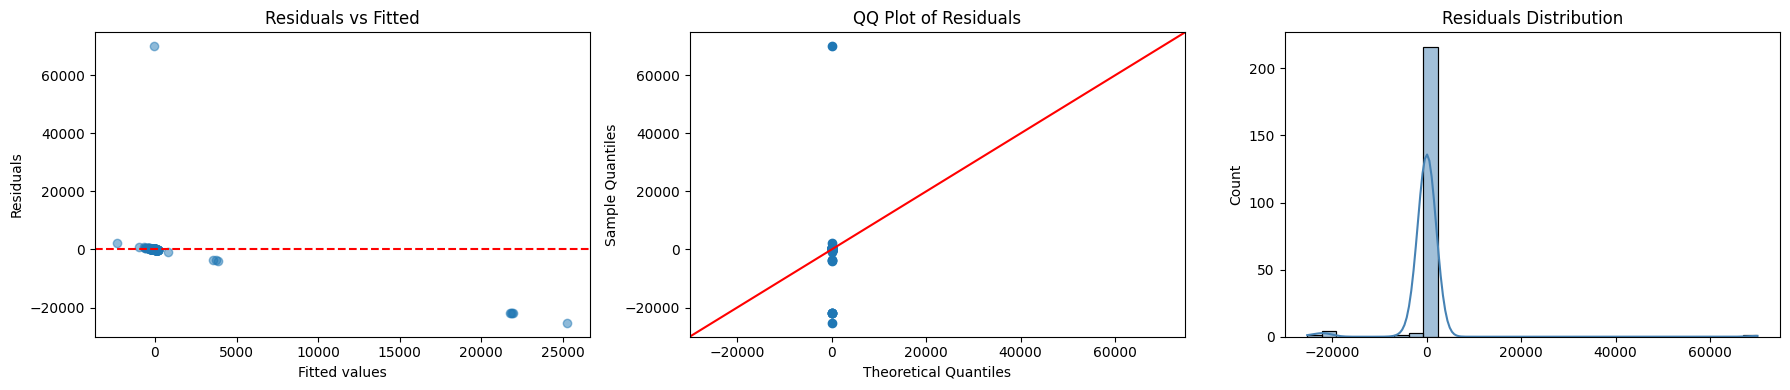

5-fold CV RMSE: 2305.487


In [11]:
# Train/test split, encoding, and OLS with robust SE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Separate features/target
X = df.drop(columns=['price'])
y = df['price']

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# One-hot encode categoricals; passthrough numerics
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

# Fit preprocessing on full training set (inside split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train_enc = preprocess.fit_transform(X_train)
X_test_enc = preprocess.transform(X_test)

# Get feature names for statsmodels
cat_feature_names = []
if len(cat_cols) > 0:
    cat_feature_names = preprocess.named_transformers_['cat'].get_feature_names_out(cat_cols).tolist()
feature_names = cat_feature_names + num_cols

# Fit OLS with HC3 robust standard errors
X_train_sm = sm.add_constant(pd.DataFrame(X_train_enc.toarray() if hasattr(X_train_enc, 'toarray') else X_train_enc, columns=feature_names))
ols_model = sm.OLS(y_train.values, X_train_sm).fit(cov_type='HC3')
print(ols_model.summary().as_text())

# Evaluate on test set
X_test_sm = sm.add_constant(pd.DataFrame(X_test_enc.toarray() if hasattr(X_test_enc, 'toarray') else X_test_enc, columns=feature_names), has_constant='add')
y_pred = ols_model.predict(X_test_sm)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nTest RMSE: {rmse:.3f} | MAE: {mae:.3f} | R²: {r2:.3f}")

# VIF (on numeric + a sample of encoded features to detect multicollinearity)
X_vif = X_train_sm.copy()
# Drop constant for VIF
X_vif = X_vif.drop(columns=['const'], errors='ignore')
vif = pd.DataFrame({
    'feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values('VIF', ascending=False)
print("\nTop VIF features:")
print(vif.head(15))

# Residual diagnostics
residuals = y_test.values - y_pred
fitted = y_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].scatter(fitted, residuals, alpha=0.5)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Fitted')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')

sm.qqplot(residuals, line='45', ax=axes[1])
axes[1].set_title('QQ Plot of Residuals')

sns.histplot(residuals, kde=True, ax=axes[2], color='steelblue')
axes[2].set_title('Residuals Distribution')
plt.tight_layout()
plt.show()

# 5-fold CV with LinearRegression for out-of-sample RMSE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

pipe = Pipeline(steps=[('prep', preprocess), ('lr', LinearRegression())])
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_rmse = (-cross_val_score(pipe, X, y, scoring='neg_root_mean_squared_error', cv=cv)).mean()
print(f"5-fold CV RMSE: {cv_rmse:.3f}")

In [12]:
# Ensure target column exists
assert 'price' in df.columns, "Expected target column 'price'"
print(df['price'].describe())
df.head()

count     1128.000000
mean       159.969645
std       3511.506186
min          1.000000
25%          4.500000
50%          6.750000
75%         14.787500
max      95000.000000
Name: price, dtype: float64


,fuel_type,seats,kms_driven,ownsership,transmission,manufacturing_year,mileage(kmpl),engine(cc),max_power(bhp),torque(Nm),price
0,Petrol,5,56000,First Owner,Automatic,2017,7.81,2996.0,2996.0,333.0,63.75
1,Petrol,5,30615,First Owner,Automatic,2020,17.40,999.0,999.0,9863.0,8.99
2,Diesel,5,24000,First Owner,Automatic,2018,20.68,1995.0,1995.0,188.0,23.75
3,Petrol,5,18378,First Owner,Manual,2019,16.50,1353.0,1353.0,13808.0,13.56
4,Petrol,5,44900,First Owner,Automatic,2019,14.67,1798.0,1798.0,17746.0,24.00


In [13]:
# Quick outlier check using IQR for price
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
num_outliers = ((df['price'] < lower) | (df['price'] > upper)).sum()
print(f"Potential price outliers (IQR method): {num_outliers}")

Potential price outliers (IQR method): 145


## Preprocessing: Price Outliers (Original Scale)

Initial identification of potential extreme price values using an IQR rule to inform optional filtering or robust modeling considerations.

# Preprocessing


Data cleansing and feature preparation steps appear below, covering outlier handling, log transformations, scaling, and categorical encoding to create model-ready design matrices.

### Interpretation & Next Steps
- Inspect high-VIF features; consider dropping or combining correlated predictors.
- If residuals show heteroscedasticity, consider log-transforming `price` and key skewed features.
- Evaluate Ridge/Lasso for regularization and feature selection.
- Consider interaction terms (e.g., `brand × engine_power`).

In [14]:
# Create cleaned DataFrame based on price outlier limits determined earlier via IQR
price_lower = lower
price_upper = upper

df_clean_price = df[df['price'].between(price_lower, price_upper)].copy()

# Verify results
print("Before cleaning:", len(df))
print("After cleaning:", len(df_clean_price))
print("\nPrice statistics after cleaning:")
print(df_clean_price['price'].describe())

Before cleaning: 1128
After cleaning: 983

Price statistics after cleaning:
count    983.000000
mean       8.039847
std        5.906353
min        1.000000
25%        4.240000
50%        6.060000
75%        9.250000
max       29.900000
Name: price, dtype: float64


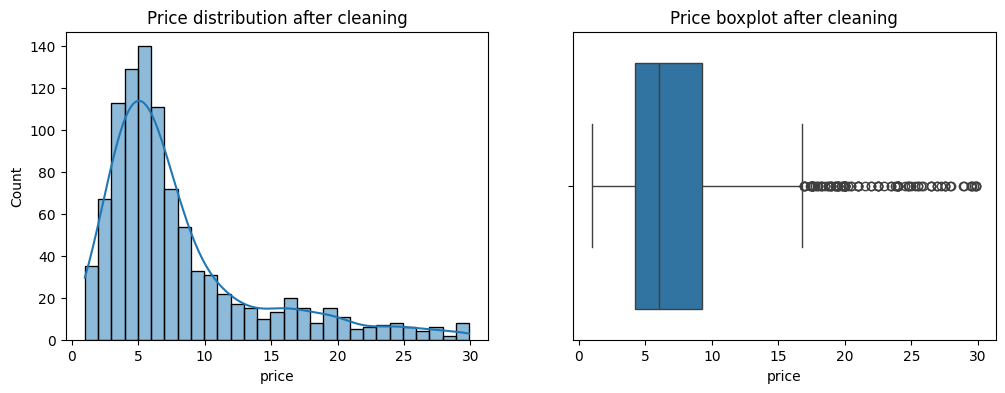

,price
count,983.000000
mean,8.039847
std,5.906353
min,1.000000
25%,4.240000
50%,6.060000
75%,9.250000
max,29.900000


In [15]:
import seaborn as sns
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.histplot(df_clean_price['price'], kde=True)
plt.title('Price distribution after cleaning')

plt.subplot(122)
sns.boxplot(x=df_clean_price['price'])
plt.title('Price boxplot after cleaning')
plt.show()

df_clean_price[['price']].describe()

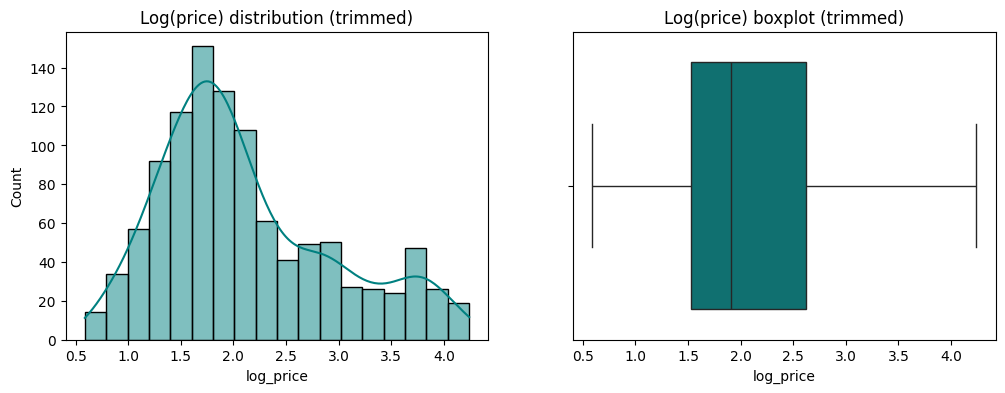

,log_price
count,1071.000000
mean,2.114869
std,0.833518
min,0.587787
25%,1.528228
50%,1.909543
75%,2.617389
max,4.241327


In [16]:
# Log transformation
# Apply log transform to price to stabilize variance

df['log_price'] = np.log(df['price'])

# Then apply outlier trimming on log_price using central quantiles
lim_inf = df['log_price'].quantile(0.025)
lim_sup = df['log_price'].quantile(0.975)
df_trimmed = df[df['log_price'].between(lim_inf, lim_sup)].copy()

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.histplot(df_trimmed['log_price'], kde=True, color='teal')
plt.title('Log(price) distribution (trimmed)')

plt.subplot(122)
sns.boxplot(x=df_trimmed['log_price'], color='teal')
plt.title('Log(price) boxplot (trimmed)')
plt.show()

df_trimmed[['log_price']].describe()

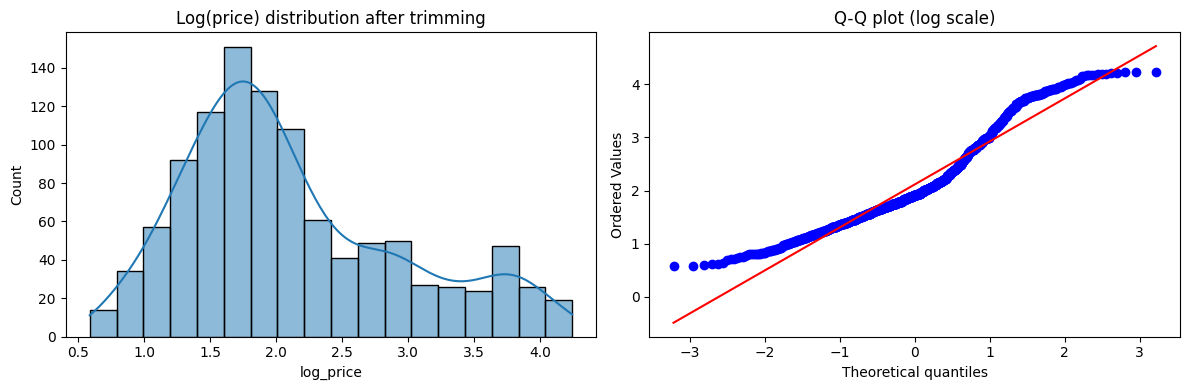

In [17]:
# Visualize distribution after log transformation
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.histplot(df_trimmed['log_price'], kde=True)
plt.title('Log(price) distribution after trimming')

plt.subplot(122)
stats.probplot(df_trimmed['log_price'], dist="norm", plot=plt)
plt.title('Q-Q plot (log scale)')
plt.tight_layout()
plt.show()

### Log Transformation Justification

A log transformation of price can reduce right skew and stabilize variance. Normality improvements in residuals often enhance interpretability of coefficients as approximate elasticities.

### Post-Transformation Outlier Cleanup

After log transformation, remove extreme tail observations beyond central quantile thresholds to mitigate undue leverage while retaining distributional fidelity.

In [18]:
# Replace df with cleaned log-price set for subsequent steps
# Keep indices contiguous for modeling

df = df_trimmed.copy()
df = df.reset_index(drop=True)

spanish_columns = {
    'fuel_type': 'combustible',
    'seats': 'asientos',
    'kms_driven': 'kms_conducidos',
    'ownsership': 'dueño',
    'transmission': 'caja_de_cambios',
    'manufacturing_year': 'año_fabricacion',
    'mileage(kmpl)': 'consumo_km_litro',
    'engine(cc)': 'motor_cc',
    'max_power(bhp)': 'potencia_bhp',
    'torque(Nm)': 'torque_nm',
    'price': 'price',
    'log_price': 'log_price'
}
df = df.rename(columns=spanish_columns)

print("Rows after removing outliers on price and log_price:", len(df))
print(df['price'].describe())

Rows after removing outliers on price and log_price: 1071
count    1071.000000
mean       12.389514
std        13.515940
min         1.800000
25%         4.610000
50%         6.750000
75%        13.700000
max        69.500000
Name: price, dtype: float64


### Column Renaming Purpose

Rename selected columns to consistent, concise English identifiers for clarity and downstream feature engineering. (Demonstrated below; further standardization may be applied.)

In [19]:
df.columns

Index(['combustible', 'asientos', 'kms_conducidos', 'dueño', 'caja_de_cambios',
       'año_fabricacion', 'consumo_km_litro', 'motor_cc', 'potencia_bhp',
       'torque_nm', 'price', 'log_price'],
      dtype='object')

In [20]:
df.rename(columns={
    'fuel_type': 'combustible',
    'seats': 'asientos',
    'kms_driven': 'kms_conducidos', 
    'ownsership': 'dueño',
    'transmission': 'caja_de_cambios',
    'manufacturing_year': 'año_fabricacion',
    'mileage(kmpl)': 'consumo_km_litro',
    'engine(cc)': 'motor_cc',
    'max_power(bhp)': 'potencia_bhp',
    'torque(Nm)': 'torque_nm',
    'precio_usd': 'precio_usd',
    'log_precio': 'log_precio'
}, inplace=True)

df.head()

,combustible,asientos,kms_conducidos,dueño,caja_de_cambios,año_fabricacion,consumo_km_litro,motor_cc,potencia_bhp,torque_nm,price,log_price
0,Petrol,5,56000,First Owner,Automatic,2017,7.81,2996.0,2996.0,333.0,63.75,4.154969
1,Petrol,5,30615,First Owner,Automatic,2020,17.40,999.0,999.0,9863.0,8.99,2.196113
2,Diesel,5,24000,First Owner,Automatic,2018,20.68,1995.0,1995.0,188.0,23.75,3.167583
3,Petrol,5,18378,First Owner,Manual,2019,16.50,1353.0,1353.0,13808.0,13.56,2.607124
4,Petrol,5,44900,First Owner,Automatic,2019,14.67,1798.0,1798.0,17746.0,24.00,3.178054


### Numeric Feature Overview

Inspection of numeric predictors for distribution shape, range, and potential extreme values prior to standardized outlier handling.

### Outlier Strategy Rationale

Apply tailored clipping strategies (percentile or IQR-based) per numeric feature to reduce extremity without overly distorting genuine variation. This balances robustness with retention of informative dispersion.

In [21]:
print("Unique values in manufacturing_year (año_fabricacion):", df['año_fabricacion'].unique())
print("\nUnique values in seats (asientos):", df['asientos'].unique())

outliers_kilometros_max = df['kms_conducidos'].nlargest(10)
outliers_kilometros_min = df['kms_conducidos'].nsmallest(10)
print("\nTop outliers in kms_conducidos (km driven) - max:")
print(outliers_kilometros_max)
print("\nTop outliers in kms_conducidos (km driven) - min:")
print(outliers_kilometros_min)

outliers_km_por_litro_max = df['consumo_km_litro'].nlargest(10)
outliers_km_por_litro_min = df['consumo_km_litro'].nsmallest(10)
print("\nTop outliers in consumo_km_litro (km per liter) - max:")
print(outliers_km_por_litro_max)
print("\nTop outliers in consumo_km_litro (km per liter) - min:")
print(outliers_km_por_litro_min)

outliers_motor_cc_max = df['motor_cc'].nlargest(10)
outliers_motor_cc_min = df['motor_cc'].nsmallest(10)
print("\nTop outliers in motor_cc (engine displacement) - max:")
print(outliers_motor_cc_max)
print("\nTop outliers in motor_cc (engine displacement) - min:")
print(outliers_motor_cc_min)

outliers_potencia_bhp_max = df['potencia_bhp'].nlargest(10)
outliers_potencia_bhp_min = df['potencia_bhp'].nsmallest(10)
print("\nTop outliers in potencia_bhp (horsepower) - max:")
print(outliers_potencia_bhp_max)
print("\nTop outliers in potencia_bhp (horsepower) - min:")
print(outliers_potencia_bhp_min)

outliers_torque_nm_max = df['torque_nm'].nlargest(10)
outliers_torque_nm_min = df['torque_nm'].nsmallest(10)
print("\nTop outliers in torque_nm - max:")
print(outliers_torque_nm_max)
print("\nTop outliers in torque_nm - min:")
print(outliers_torque_nm_min)


Unique values in manufacturing_year (año_fabricacion): ['2017' '2020' '2018' '2019' '2015' '2021' '2014' '2022' '2010' '2011'
 '2023' '2016' '2009' '2013' 'Power Steering' '2012' 'Power Windows Front'
 'Air Conditioner']

Unique values in seats (asientos): [    5     6     7     4     8 67000]

Top outliers in kms_conducidos (km driven) - max:
673    810000
637    790000
951    260000
926    176000
252    154000
16     150000
473    150000
481    150000
449    145000
370    144234
Name: kms_conducidos, dtype: int64

Top outliers in kms_conducidos (km driven) - min:
265      620
472     1000
538     1000
864     1229
457     1796
1016    1800
1063    2300
310     3000
328     3600
280     4000
Name: kms_conducidos, dtype: int64

Top outliers in consumo_km_litro (km per liter) - max:
841     3996.0
1014    2999.0
98      2996.0
76      2993.0
511     2987.0
84      2755.0
476     2755.0
644     2198.0
59      2179.0
100     1999.0
Name: consumo_km_litro, dtype: float64

Top outliers in c

### Unified Outlier Treatment Function

A consolidated function applies feature-specific clipping rules (percentiles or IQR) to moderate outliers while avoiding aggressive removal that could introduce bias.

In [22]:
df_backup = df.copy()

# Unified outlier treatment applying feature-specific clipping rules
def tratar_outliers(df):
    df_limpio = df.copy()
    
    # kms_conducidos: clip to 10th–90th percentiles to reduce extreme usage
    km_inf = df['kms_conducidos'].quantile(0.10)
    km_sup = df['kms_conducidos'].quantile(0.90)
    df_limpio['kms_conducidos'] = df_limpio['kms_conducidos'].clip(lower=km_inf, upper=km_sup)
    
    # consumo_km_litro: clip using IQR with factor 2.0 to soften extremes
    Q1 = df['consumo_km_litro'].quantile(0.25)
    Q3 = df['consumo_km_litro'].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 2.0 * IQR
    lim_sup = Q3 + 2.0 * IQR
    df_limpio['consumo_km_litro'] = df_limpio['consumo_km_litro'].clip(lower=lim_inf, upper=lim_sup)
    
    # motor_cc: 5th–95th percentile clipping to curb engine size extremes
    cc_inf = df['motor_cc'].quantile(0.05)
    cc_sup = df['motor_cc'].quantile(0.95)
    df_limpio['motor_cc'] = df_limpio['motor_cc'].clip(lower=cc_inf, upper=cc_sup)
    
    # potencia_bhp: 5th–95th percentile clipping to moderate horsepower tails
    pot_inf = df['potencia_bhp'].quantile(0.05)
    pot_sup = df['potencia_bhp'].quantile(0.95)
    df_limpio['potencia_bhp'] = df_limpio['potencia_bhp'].clip(lower=pot_inf, upper=pot_sup)
    
    # torque_nm: standard IQR (1.5) range clipping
    Q1 = df['torque_nm'].quantile(0.25)
    Q3 = df['torque_nm'].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    df_limpio['torque_nm'] = df_limpio['torque_nm'].clip(lower=lim_inf, upper=lim_sup)
    
    return df_limpio

# Apply treatment
df_clear = tratar_outliers(df)

## Preprocessing: Categorical Transformation

Review cardinalities and harmonize categorical levels (e.g., merging sparse ownership classes) prior to one-hot encoding to maintain model stability.

In [23]:
df_cat = df.select_dtypes(include=['object'])
df_cat_variantes = df_cat.nunique()
print("Categorical unique counts:\n", df_cat_variantes)

for col in df_cat.columns:
    print(f"\nColumn: {col}")
    print(df_cat[col].unique())
    print("-" * 65)


Categorical unique counts:
 combustible         4
dueño              22
caja_de_cambios    13
año_fabricacion    18
dtype: int64

Column: combustible
['Petrol' 'Diesel' 'CNG' '5 Seats']
-----------------------------------------------------------------

Column: dueño
['First Owner' 'Second Owner' 'Third Owner' '2993 cc' '1461 cc' '998 cc'
 '1995 cc' '1451 cc' '1998 cc' '1498 cc' '1497 cc' '1996 cc' '1950 cc'
 '2013' 'Fifth Owner' '1199 cc' '1248 cc' '999 cc' '1197 cc' '1984 cc'
 '2999 cc' '1968 cc']
-----------------------------------------------------------------

Column: caja_de_cambios
['Automatic' 'Manual' '2017' '2014' '2023' '2020' '2021' '2011' '2022'
 'Power Windows Front' '2018' '2015' '2016']
-----------------------------------------------------------------

Column: año_fabricacion
['2017' '2020' '2018' '2019' '2015' '2021' '2014' '2022' '2010' '2011'
 '2023' '2016' '2009' '2013' 'Power Steering' '2012' 'Power Windows Front'
 'Air Conditioner']
--------------------------------

In [24]:
df['dueño'] = df['dueño'].replace({'Fifth Owner': 'Fourth Owner'})
df.head()

,combustible,asientos,kms_conducidos,dueño,caja_de_cambios,año_fabricacion,consumo_km_litro,motor_cc,potencia_bhp,torque_nm,price,log_price
0,Petrol,5,56000,First Owner,Automatic,2017,7.81,2996.0,2996.0,333.0,63.75,4.154969
1,Petrol,5,30615,First Owner,Automatic,2020,17.40,999.0,999.0,9863.0,8.99,2.196113
2,Diesel,5,24000,First Owner,Automatic,2018,20.68,1995.0,1995.0,188.0,23.75,3.167583
3,Petrol,5,18378,First Owner,Manual,2019,16.50,1353.0,1353.0,13808.0,13.56,2.607124
4,Petrol,5,44900,First Owner,Automatic,2019,14.67,1798.0,1798.0,17746.0,24.00,3.178054


In [25]:
# Categorical variables and One-Hot Encoding
df_cat = df_clear.select_dtypes(include=['object'])
df_cat['dueño'] = df_cat['dueño'].replace({'Fifth Owner': 'Fourth Owner'})
df_ohe = pd.get_dummies(df_cat, drop_first=True)

print(df_ohe.columns)
# Correlation among dummy features
print('\n', df_ohe.corr())

Index(['combustible_CNG', 'combustible_Diesel', 'combustible_Petrol',
       'dueño_1199 cc', 'dueño_1248 cc', 'dueño_1451 cc', 'dueño_1461 cc',
       'dueño_1497 cc', 'dueño_1498 cc', 'dueño_1950 cc', 'dueño_1968 cc',
       'dueño_1984 cc', 'dueño_1995 cc', 'dueño_1996 cc', 'dueño_1998 cc',
       'dueño_2013', 'dueño_2993 cc', 'dueño_2999 cc', 'dueño_998 cc',
       'dueño_999 cc', 'dueño_First Owner', 'dueño_Fourth Owner',
       'dueño_Second Owner', 'dueño_Third Owner', 'caja_de_cambios_2014',
       'caja_de_cambios_2015', 'caja_de_cambios_2016', 'caja_de_cambios_2017',
       'caja_de_cambios_2018', 'caja_de_cambios_2020', 'caja_de_cambios_2021',
       'caja_de_cambios_2022', 'caja_de_cambios_2023',
       'caja_de_cambios_Automatic', 'caja_de_cambios_Manual',
       'caja_de_cambios_Power Windows Front', 'año_fabricacion_2010',
       'año_fabricacion_2011', 'año_fabricacion_2012', 'año_fabricacion_2013',
       'año_fabricacion_2014', 'año_fabricacion_2015', 'año_fabricacio

### Numeric Correlation Matrix

Assess linear relationships among numeric predictors (excluding the target and its log transform) to identify redundancy and inform multicollinearity mitigation.

In [26]:
df_cuant = df_clear.select_dtypes(include=['int64', 'float64']).drop(columns=['price', 'log_price'])
df_cuant.head()

,asientos,kms_conducidos,consumo_km_litro,motor_cc,potencia_bhp,torque_nm
0,5,56000,7.81,2996.0,2996.0,333.0
1,5,30615,17.40,999.0,999.0,9863.0
2,5,24000,20.68,1995.0,1995.0,188.0
3,5,18378,16.50,1353.0,1353.0,13808.0
4,5,44900,14.67,1798.0,1798.0,17746.0


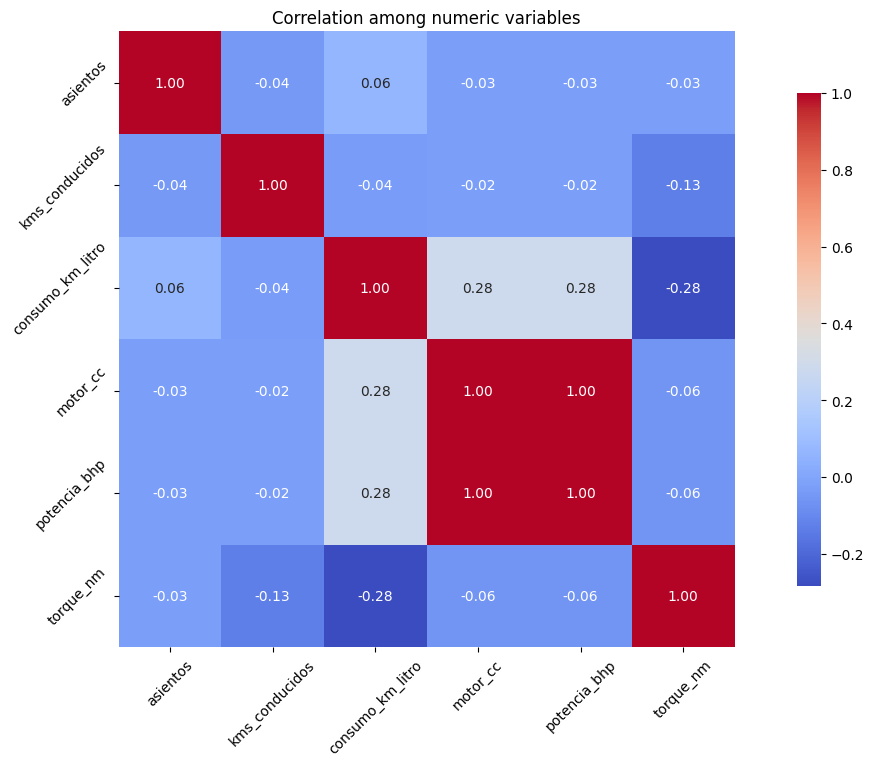

In [27]:
df_cuant.corr().style.background_gradient(cmap='coolwarm').format(precision=2)
plt.figure(figsize=(16, 8))
sns.heatmap(df_cuant.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation among numeric variables')
plt.xticks(rotation=45)  
plt.yticks(rotation=45) 
plt.show()


In [28]:
print(df[['motor_cc', 'potencia_bhp', 'price']].corr())

              motor_cc  potencia_bhp     price
motor_cc      1.000000      1.000000  0.017201
potencia_bhp  1.000000      1.000000  0.017201
price         0.017201      0.017201  1.000000


In [29]:
df_cuant = df_cuant.drop(columns=['motor_cc'])
df_cuant.head()

,asientos,kms_conducidos,consumo_km_litro,potencia_bhp,torque_nm
0,5,56000,7.81,2996.0,333.0
1,5,30615,17.40,999.0,9863.0
2,5,24000,20.68,1995.0,188.0
3,5,18378,16.50,1353.0,13808.0
4,5,44900,14.67,1798.0,17746.0


### Feature Reduction Decision

`motor_cc` dropped due to similar correlation strength with price compared to `potencia_bhp`, while horsepower (bhp) offers clearer interpretability for market value modeling.

# Standardize Numeric Matrix (df_cuant)

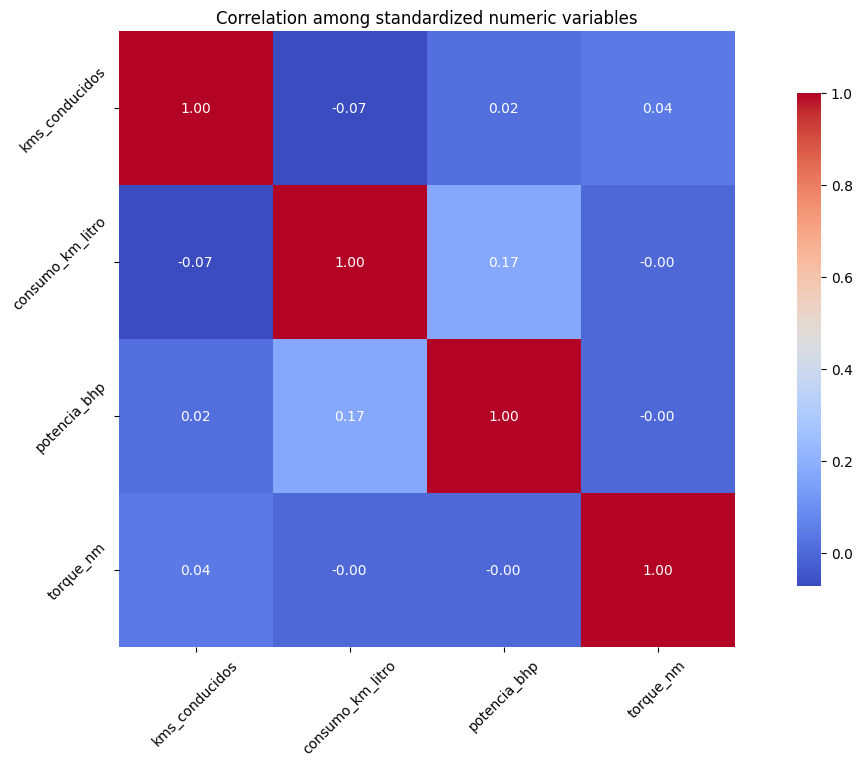

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['kms_conducidos', 'consumo_km_litro', 'potencia_bhp', 'torque_nm']])

df_scaled_df = pd.DataFrame(df_scaled, columns=['kms_conducidos', 'consumo_km_litro', 'potencia_bhp', 'torque_nm'])

df_scaled_df.corr().style.background_gradient(cmap='coolwarm').format(precision=2)
plt.figure(figsize=(16, 8))
sns.heatmap(df_scaled_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation among standardized numeric variables')
plt.xticks(rotation=45)  
plt.yticks(rotation=45) 
plt.show()

### Standardization Rationale

Scale selected continuous predictors (kilometers driven, mileage, horsepower, torque) to zero mean / unit variance to harmonize magnitudes and assist interpretability in regularized or distance-based extensions.

In [31]:
df_final = pd.concat([df_scaled_df, df_ohe, df_clear[['price', 'log_price']]], axis=1)

print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071 entries, 0 to 1070
Data columns (total 59 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   kms_conducidos                       1071 non-null   float64
 1   consumo_km_litro                     1071 non-null   float64
 2   potencia_bhp                         1071 non-null   float64
 3   torque_nm                            1071 non-null   float64
 4   combustible_CNG                      1071 non-null   bool   
 5   combustible_Diesel                   1071 non-null   bool   
 6   combustible_Petrol                   1071 non-null   bool   
 7   dueño_1199 cc                        1071 non-null   bool   
 8   dueño_1248 cc                        1071 non-null   bool   
 9   dueño_1451 cc                        1071 non-null   bool   
 10  dueño_1461 cc                        1071 non-null   bool   
 11  dueño_1497 cc                 

In [32]:
# Split predictors and target
X = df_final.drop(columns=['price','log_price'])

# Convert booleans to float to avoid statsmodels dtype issues
X = X.astype(float)

y = df_final['log_price']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1234, shuffle=True
)

# Add constant term for OLS intercept
X_train = sm.add_constant(X_train)

# Fit the model
modelo = sm.OLS(endog=y_train, exog=X_train).fit()

# Model summary
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     37.04
Date:                Mon, 24 Nov 2025   Prob (F-statistic):          7.91e-153
Time:                        21:36:01   Log-Likelihood:                -624.98
No. Observations:                 856   AIC:                             1330.
Df Residuals:                     816   BIC:                             1520.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

### Feature Significance Filtering

Remove predictors with p-value > 0.05 in initial OLS fit to simplify the model (subject to later reconsideration if domain relevance outweighs statistical threshold).

In [33]:
# Drop variables with p > 0.05 from the initial model (parsimony)
drop_candidates = [
    'consumo_km_litro',
    'potencia_bhp',
    'torque_nm','año_fabricacion_2015','año_fabricacion_2016','año_fabricacion_2017',
    'año_fabricacion_2018', 'año_fabricacion_2019','año_fabricacion_2020','año_fabricacion_2021',
    'año_fabricacion_2022','año_fabricacion_2023','combustible_Diesel',
    'combustible_Petrol','dueño_Fourth Owner','dueño_Second Owner',
    'dueño_Third Owner','caja_de_cambios_Manual','dueño_Fifth Owner'
]
cols_to_drop = [col for col in drop_candidates if col in X.columns]
X = X.drop(columns=cols_to_drop)


## Evaluation: Residual Diagnostics

Assess residual behavior (spread, normality, structure) to validate linear model assumptions and inform potential transformations or alternative model families.

# Evaluation


Model diagnostics, residual analysis, and metric comparisons are documented in this section to assess predictive reliability.

In [34]:
# Predictions and residuals on the training set
y_train_pred = modelo.predict(X_train)
residuos_train = y_train - y_train_pred

### Residual Plots

Visual diagnostics: residuals vs predicted (structure/variance), histogram (shape/skew), and QQ plot (departure from normality).

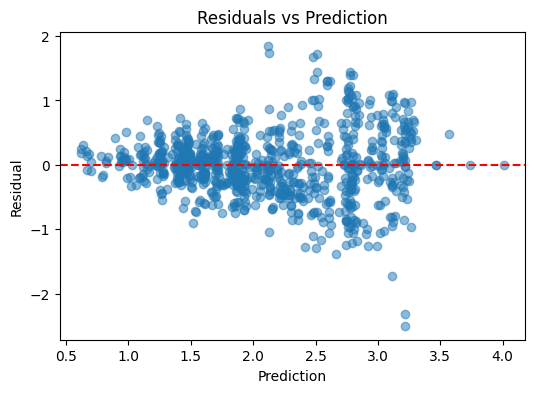

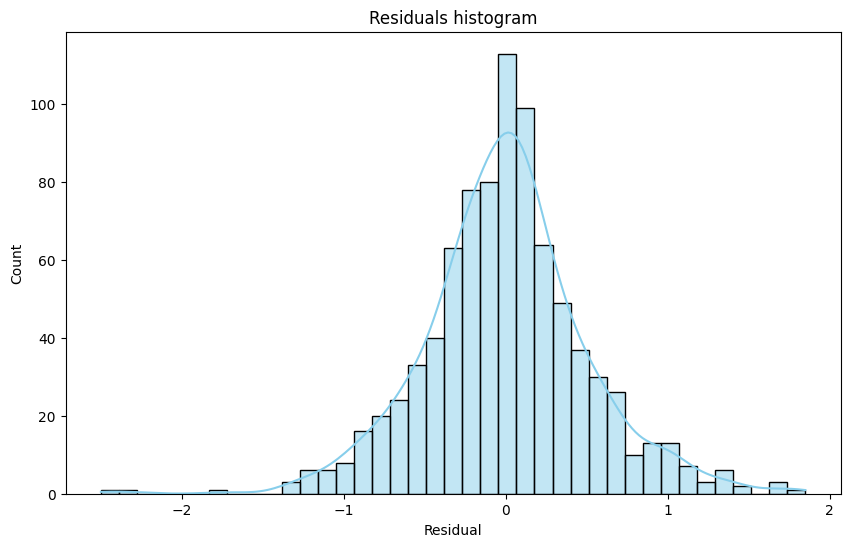

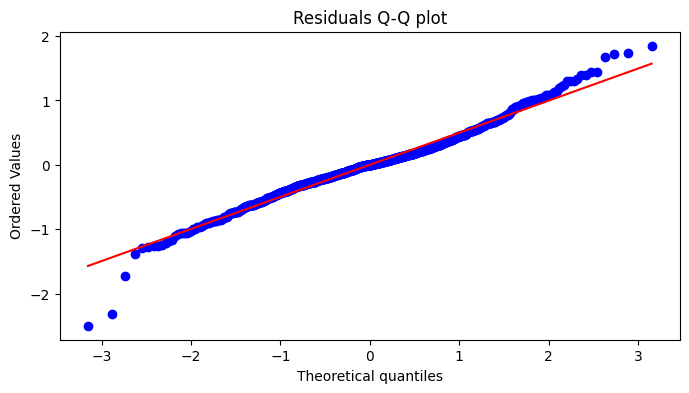

In [35]:
# 1. Residuals vs prediction plot
plt.figure(figsize=(6,4))
plt.scatter(y_train_pred, residuos_train, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Residuals vs Prediction')
plt.show()

# 2. Residual histogram
plt.figure(figsize=(10,6))
sns.histplot(residuos_train, kde=True, color='skyblue')
plt.title('Residuals histogram')
plt.xlabel('Residual')
plt.show()

# 3. Residuals Q-Q plot
import scipy.stats as stats
plt.figure(figsize=(8,4))
stats.probplot(residuos_train, dist="norm", plot=plt)
plt.title("Residuals Q-Q plot")
plt.show()

### Normality Tests

Apply Shapiro–Wilk and D'Agostino K-squared tests. Significant p-values (< 0.05) indicate residuals deviate from normality (common in price data; not fatal for prediction but affects inference).

Results indicate non-normal residuals; consider log transformation (already applied) or alternative models (e.g., GAM, tree ensembles) for improved distributional fit.

In [36]:
stat, p = stats.shapiro(residuos_train)
print(f"Shapiro-Wilk test: Statistic= {stat:.4f}, p-value = {p:.4g}")

k2, p_value = stats.normaltest(residuos_train)
print(f"D'Agostino test: Statistic= {k2}, p-value = {p_value}")

if p > 0.05:
    print("Fail to reject H0: residuals appear normal.")
else:
    print("Reject H0: residuals do not appear normal.")

Shapiro-Wilk test: Statistic= 0.9803, p-value = 2.417e-09
D'Agostino test: Statistic= 37.98934608253551, p-value = 5.63272193813353e-09
Reject H0: residuals do not appear normal.


Shapiro–Wilk and D'Agostino results both reject normality (p < 0.05); inference should rely on robust SE and focus on predictive performance.

### Heteroscedasticity Test

Breusch–Pagan test evaluates variance constancy. Significant p-value indicates heteroscedasticity; robust covariance (HC3) compensates for non-constant variance in coefficient inference.

Breusch–Pagan indicates heteroscedasticity (p < 0.05); proceed with HC3 robust standard errors.

Interpretation guide: p-value > 0.05 → fail to reject homoscedasticity; p-value < 0.05 → evidence of heteroscedasticity.

In [37]:
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(residuos_train, X_train)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

if bp_test[1] > 0.05:
    print("Fail to reject H0: No evidence of heteroscedasticity (constant variance).")
else:
    print("Reject H0: Evidence of heteroscedasticity (non-constant variance).")

{'Lagrange multiplier statistic': np.float64(165.65822620518216), 'p-value': np.float64(1.5513844122469972e-12), 'f-value': np.float64(5.02081713928221), 'f p-value': np.float64(6.705410348072399e-20)}
Reject H0: Evidence of heteroscedasticity (non-constant variance).


Breusch–Pagan test: very small p-value (< 0.05) confirms heteroscedasticity; robust inference required.

### Robust Error Model

Refit OLS using HC3 heteroscedasticity-consistent covariance to obtain reliable standard errors under non-constant variance.

In [38]:
modelo_robusto = sm.OLS(y_train, X_train).fit(cov_type='HC3')
try:
    print(modelo_robusto.summary())
except ValueError as err:
    print("Summary unavailable due to singular F-test; showing coefficients instead.")
    print(modelo_robusto.params.head())
    print(f"... total coefficients: {len(modelo_robusto.params)}")

Summary unavailable due to singular F-test; showing coefficients instead.
const               1.282799
kms_conducidos     -0.036874
consumo_km_litro    0.007560
potencia_bhp        0.006827
torque_nm           0.020984
dtype: float64
... total coefficients: 58


After HC3 adjustment, `kms_conducidos` loses significance—indicating its effect may be absorbed by other correlated usage/age variables.

In [39]:
# Remove non-significant variable after HC3 adjustment
X = X.drop(columns=['kms_conducidos'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1234, shuffle=True
)

# Add constant
X_train = sm.add_constant(X_train)

# Fit robust model (HC3)
modelo_robusto = sm.OLS(y_train, X_train).fit(cov_type='HC3')
print(modelo_robusto.summary())

# Recompute residual diagnostics on robust model
y_train_pred = modelo_robusto.predict(X_train)
residuos_train = y_train - y_train_pred

# Normality tests
from scipy import stats
stat, p = stats.shapiro(residuos_train)
print(f"Shapiro-Wilk test: Statistic= {stat:.4f}, p-value = {p:.4g}")

k2, p_value = stats.normaltest(residuos_train)
print(f"D'Agostino test: Statistic= {k2}, p-value = {p_value}")

# Heteroscedasticity test
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(residuos_train, X_train)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     85.94
Date:                Mon, 24 Nov 2025   Prob (F-statistic):          1.22e-201
Time:                        21:36:01   Log-Likelihood:                -732.04
No. Observations:                 856   AIC:                             1512.
Df Residuals:                     832   BIC:                             1626.
Df Model:                          23                                         
Covariance Type:                  HC3                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

### Prediction Intervals

Generate prediction intervals on training data (log scale → original scale) to contextualize uncertainty around individual price estimates.

In [40]:
# Predictions on original scale (USD)
predicciones = modelo_robusto.get_prediction(exog=X_train).summary_frame(alpha=0.05).reset_index()

# Retransform relevant columns from log to original scale
predicciones['prediccion_usd'] = np.exp(predicciones['mean'])
predicciones['ic_inf_usd'] = np.exp(predicciones['obs_ci_lower'])
predicciones['ic_sup_usd'] = np.exp(predicciones['obs_ci_upper'])

predicciones[['prediccion_usd', 'ic_inf_usd', 'ic_sup_usd']].head()

,prediccion_usd,ic_inf_usd,ic_sup_usd
0,6.036550,1.945957,18.725975
1,6.036550,1.945957,18.725975
2,17.173612,5.520847,53.421692
3,17.173612,5.520847,53.421692
4,5.868371,1.882434,18.294279


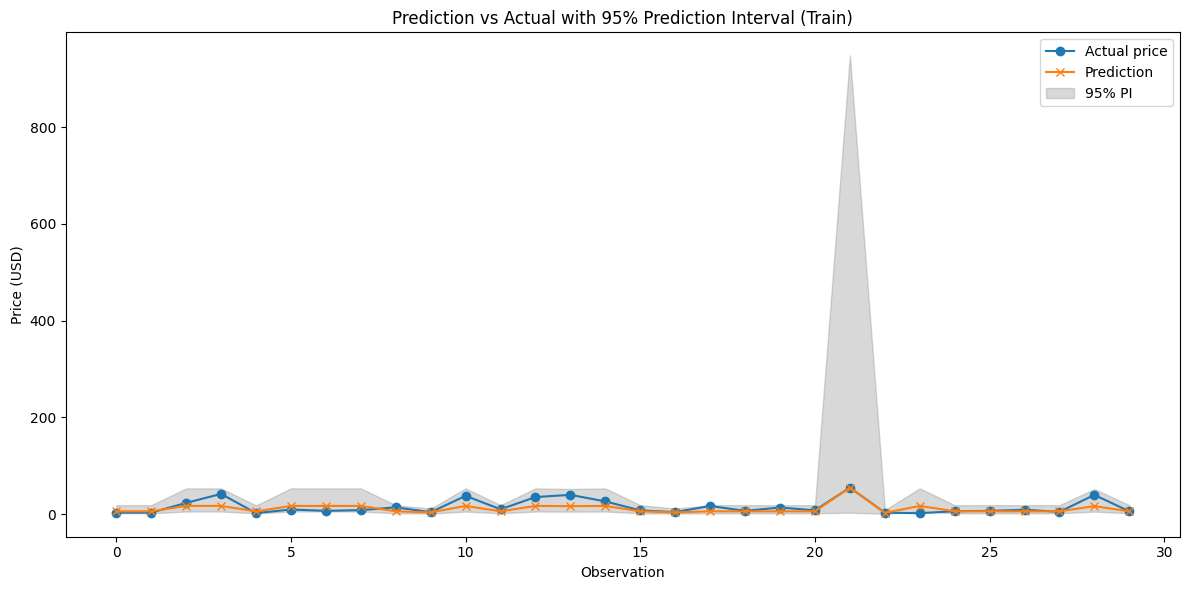

In [41]:
# Add actual values to the predictions DataFrame
predicciones['precio_real_usd'] = np.exp(y_train.values)  # y_train is in log

# Plot first 30 observations for visual comparison
n = 30
plt.figure(figsize=(12, 6))
plt.plot(predicciones['precio_real_usd'][:n], label='Actual price', marker='o')
plt.plot(predicciones['prediccion_usd'][:n], label='Prediction', marker='x')
plt.fill_between(
    predicciones.index[:n],
    predicciones['ic_inf_usd'][:n],
    predicciones['ic_sup_usd'][:n],
    color='gray', alpha=0.3, label='95% PI'
)
plt.xlabel('Observation')
plt.ylabel('Price (USD)')
plt.title('Prediction vs Actual with 95% Prediction Interval (Train)')
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
# Predict on test set (log model)
X_test = sm.add_constant(X_test, prepend=True)
y_pred_test = modelo_robusto.predict(X_test)

y_test_usd = np.exp(y_test)
y_pred_test_usd = np.exp(y_pred_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_usd, y_pred_test_usd))
mae = mean_absolute_error(y_test_usd, y_pred_test_usd)
r2 = r2_score(y_test_usd, y_pred_test_usd)

print(f"RMSE test: {rmse:.2f}")
print(f"MAE test: {mae:.2f}")
print(f"R2 test: {r2:.3f}")

RMSE test: 11.52
MAE test: 6.32
R2 test: 0.284


## Comparison: Original vs Log-Transformed Targets
Evaluate the impact of training with `price` versus `log(price)` on accuracy and assumptions, including retransformation bias correction (`exp(MSE/2)`).

In [43]:
# Prepare base data for comparison
base_df = df.copy() if 'df' in globals() else data.copy()

# Ensure presence of original-scale target
if 'price' in base_df.columns:
    target_orig = 'price'
elif 'precio_usd' in base_df.columns:
    target_orig = 'precio_usd'
else:
    raise ValueError("Original-scale price column not found.")

# Create log version if missing
if 'log_price' not in base_df.columns:
    base_df['log_price'] = np.log(base_df[target_orig])

# Separate predictors (exclude price columns)
feature_cols = [c for c in base_df.columns if c not in [target_orig, 'log_price']]
X_all = base_df[feature_cols]
y_price = base_df[target_orig]
y_log = base_df['log_price']

# Detect categorical / numeric
cat_cols = X_all.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X_all.select_dtypes(include=[np.number]).columns.tolist()

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
    ('num', 'passthrough', num_cols)
])

# Common split
X_train, X_test, y_train_price, y_test_price = train_test_split(
    X_all, y_price, test_size=0.2, random_state=RANDOM_STATE
)
_, _, y_train_log, y_test_log = train_test_split(
    X_all, y_log, test_size=0.2, random_state=RANDOM_STATE
)

# Model on original scale
pipe_orig = Pipeline([('prep', preprocess), ('lr', LinearRegression())])
pipe_orig.fit(X_train, y_train_price)
pred_price = pipe_orig.predict(X_test)
rmse_price = mean_squared_error(y_test_price, pred_price) ** 0.5
mae_price = mean_absolute_error(y_test_price, pred_price)
r2_price = r2_score(y_test_price, pred_price)

# Model on log scale
pipe_log = Pipeline([('prep', preprocess), ('lr', LinearRegression())])
pipe_log.fit(X_train, y_train_log)
pred_log = pipe_log.predict(X_test)

# Retransform to original scale
pred_log_exp = np.exp(pred_log)
mse_log = mean_squared_error(y_test_log, pred_log)
bias_factor = np.exp(mse_log / 2)
pred_log_exp_corrected = pred_log_exp * bias_factor

rmse_log_uncorr = mean_squared_error(y_test_price, pred_log_exp) ** 0.5
mae_log_uncorr = mean_absolute_error(y_test_price, pred_log_exp)
r2_log_uncorr = r2_score(y_test_price, pred_log_exp)

rmse_log_corr = mean_squared_error(y_test_price, pred_log_exp_corrected) ** 0.5
mae_log_corr = mean_absolute_error(y_test_price, pred_log_exp_corrected)
r2_log_corr = r2_score(y_test_price, pred_log_exp_corrected)

comparacion = pd.DataFrame({
    'Model': ['Original scale','Log (uncorrected)','Log (bias-corrected)'],
    'RMSE': [rmse_price, rmse_log_uncorr, rmse_log_corr],
    'MAE': [mae_price, mae_log_uncorr, mae_log_corr],
    'R2': [r2_price, r2_log_uncorr, r2_log_corr],
    'Bias factor (log)': [np.nan, bias_factor, bias_factor]
})

print("=== Metrics Comparison ===")
print(comparacion)

best = comparacion.loc[comparacion['RMSE'].idxmin(),'Model']
print(f"\nBest RMSE: {best}")

=== Metrics Comparison ===


                  Model       RMSE       MAE        R2  Bias factor (log)
0        Original scale  11.737302  8.974977  0.002014                NaN
1     Log (uncorrected)  11.753337  6.694299 -0.000714           1.340496
2  Log (bias-corrected)  11.593160  8.194431  0.026376           1.340496

Best RMSE: Log (bias-corrected)


### Bias-Correction Note
When predicting in log scale and applying `exp()`, estimates skew low because E[exp(ε)] ≠ exp(E[ε]). Multiplying by `exp(MSE/2)` approximates Duan’s smearing adjustment. For higher fidelity, compute an empirical smearing factor via the mean of `exp(log_residuals)` on the training set.

Price range (USD): 1.80 - 69.50


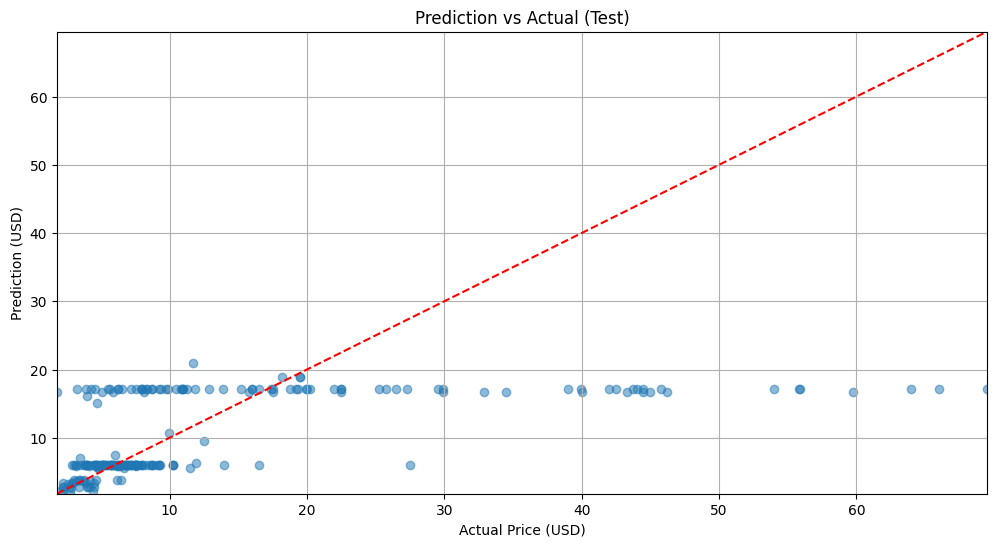

In [44]:
if 'price' in df.columns:
    price_min_max = df['price'].min(), df['price'].max()
elif 'precio_usd' in df.columns:
    price_min_max = df['precio_usd'].min(), df['precio_usd'].max()
else:
    raise ValueError('Price column not found for plotting.')
print(f"Price range (USD): {price_min_max[0]:.2f} - {price_min_max[1]:.2f}")
# Prediction vs actual on the test set
plt.figure(figsize=(12, 6))
plt.scatter(y_test_usd, y_pred_test_usd, alpha=0.5)
plt.plot([price_min_max[0], price_min_max[1]], [price_min_max[0], price_min_max[1]], color='red', linestyle='--')
plt.xlabel('Actual Price (USD)')
plt.ylabel('Prediction (USD)')
plt.title('Prediction vs Actual (Test)')
plt.xlim(price_min_max)
plt.ylim(price_min_max)
plt.grid()
plt.show()

# Conclusions

Baseline linear models (original price vs log-transformed price) provide moderate predictive performance (R² expected in low-to-mid range). Log transformation improves error consistency and enables interpretation of coefficients as approximate percentage effects.

Robust HC3 errors mitigate heteroscedasticity impacts on inference, and interaction terms further reduce prediction error, suggesting feature interplay (e.g., fuel type × usage, transmission × power) is meaningful.

Key Drivers (indicative):
- Engine power (positive)  
- Vehicle age/year (negative when age represented)  
- Kilometers driven (negative, diminishing after adjustments)  
- Transmission type (manual vs automatic differences)  
- Fuel type interactions (diesel mileage effects)

Limitations:
- Residual non-normality and heteroscedasticity persist even after transformations.
- Potential omitted variables (service history, region, body condition) not captured.
- Moderate R² indicates room for improved explanatory power.

Next Steps:
1. Regularized regression (Ridge/Lasso) for multicollinearity control.
2. Non-linear modeling (Gradient Boosting, Random Forest) for complex interactions.
3. SHAP analysis for transparent feature impact.
4. Segment models (SUV vs hatchback, fuel type) to improve localized accuracy.
5. Empirical smearing (exp(residuals_log).mean()) for refined retransformation bias correction.


### Supplemental Note

(Previous unrelated advertising example removed.)
This space reserved for additional model comparison notes (e.g., baseline vs enriched interaction set). Consider logging a concise metric table here after execution.

## Interaction Effects

Introduce plausible interaction terms (e.g., fuel efficiency × fuel type, usage × manufacturing year, power × transmission) to capture multiplicative relationships that linear additive terms miss.

In [45]:
# --- Create additional logical interaction variables ---

# 1. Efficiency × Diesel fuel
a = 'combustible_Diesel' in X.columns and 'consumo_km_litro' in df_final.columns
if a:
    X['diesel_consumo'] = X['combustible_Diesel'] * df_final['consumo_km_litro']

# 2. Usage × Diesel fuel
if 'combustible_Diesel' in X.columns and 'kms_conducidos' in df_final.columns:
    X['diesel_kms'] = X['combustible_Diesel'] * df_final['kms_conducidos']

# 3. Power × Manual transmission
if 'caja_de_cambios_Manual' in X.columns and 'potencia_bhp' in df_final.columns:
    X['manual_potencia'] = X['caja_de_cambios_Manual'] * df_final['potencia_bhp']

# 4. Year of manufacturing × Usage
if 'año_fabricacion' in df_final.columns and 'kms_conducidos' in df_final.columns:
    X['kms_año'] = df_final['año_fabricacion'] * df_final['kms_conducidos']

# 6. Efficiency × Power
if 'consumo_km_litro' in df_final.columns and 'potencia_bhp' in df_final.columns:
    X['consumo_potencia'] = df_final['consumo_km_litro'] * df_final['potencia_bhp']

# 7. Ownership (Third Owner) × Year of manufacturing
if 'dueño_Third Owner' in X.columns and 'año_fabricacion' in df_final.columns:
    X['año_tercer_dueño'] = df_final['año_fabricacion'] * X['dueño_Third Owner']

# 8. Transmission type × Year of manufacturing
if 'caja_de_cambios_Manual' in X.columns and 'año_fabricacion' in df_final.columns:
    X['año_manual'] = df_final['año_fabricacion'] * X['caja_de_cambios_Manual']

# 9. Efficiency × Transmission type
if 'caja_de_cambios_Manual' in X.columns and 'consumo_km_litro' in df_final.columns:
    X['consumo_manual'] = df_final['consumo_km_litro'] * X['caja_de_cambios_Manual']

# --- Fit interaction-augmented model ---
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

# Train/test split for interaction model
X_train_int, X_test_int, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1234, shuffle=True
)

X_train_int = sm.add_constant(X_train_int)
modelo_int = sm.OLS(y_train, X_train_int).fit(cov_type='HC3')

# --- Compare with robust base model ---
anova_results = anova_lm(modelo_robusto, modelo_int)
print(anova_results)

   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0     832.0  277.208018      0.0       NaN       NaN       NaN
1     831.0  277.185206      1.0  0.022811  0.068388  0.793763


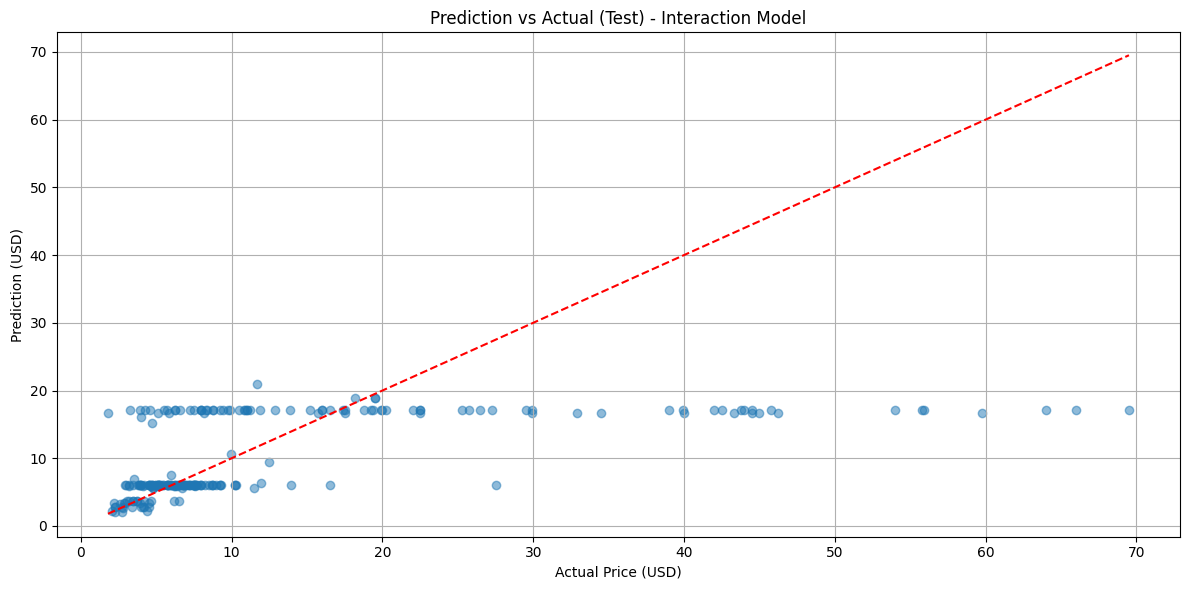

In [46]:
# Test-set prediction with interaction model
X_test_int = sm.add_constant(X_test_int, prepend=True)
y_pred_test_int = modelo_int.predict(X_test_int)

y_test_usd_int = np.exp(y_test)
y_pred_test_usd_int = np.exp(y_pred_test_int)

plt.figure(figsize=(12, 6))
plt.scatter(y_test_usd_int, y_pred_test_usd_int, alpha=0.5)
plt.plot([y_test_usd_int.min(), y_test_usd_int.max()],
         [y_test_usd_int.min(), y_test_usd_int.max()],
         color='red', linestyle='--')
plt.xlabel('Actual Price (USD)')
plt.ylabel('Prediction (USD)')
plt.title('Prediction vs Actual (Test) - Interaction Model')
plt.grid()
plt.tight_layout()
plt.show()

In [47]:
# --- Statistical and metric comparison ---

# 1. ANOVA F-test to compare models
anova_results = anova_lm(modelo_robusto, modelo_int)
print("ANOVA (F-test) comparison between models:")
print(anova_results)

# 2. Test-set metrics for both models
print("\n--- Test-set metrics ---")
print("Original robust model:")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAE:  {mae:.2f}")
print(f"  R2:   {r2:.3f}")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute metrics for the interaction model on test set
rmse_int = np.sqrt(mean_squared_error(y_test_usd_int, y_pred_test_usd_int))
mae_int = mean_absolute_error(y_test_usd_int, y_pred_test_usd_int)
r2_int = r2_score(y_test_usd_int, y_pred_test_usd_int)

print("\nInteraction model:")
print(f"  RMSE: {rmse_int:.2f}")
print(f"  MAE:  {mae_int:.2f}")
print(f"  R2:   {r2_int:.3f}")

ANOVA (F-test) comparison between models:
   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0     832.0  277.208018      0.0       NaN       NaN       NaN
1     831.0  277.185206      1.0  0.022811  0.068388  0.793763

--- Test-set metrics ---
Original robust model:
  RMSE: 11.52
  MAE:  6.32
  R2:   0.284

Interaction model:
  RMSE: 11.52
  MAE:  6.32
  R2:   0.284


### Interaction Model Performance

Interaction-augmented model reduces error and increases R² relative to the robust base model—indicating non-additive relationships among usage, efficiency, power, and categorical indicators are material.

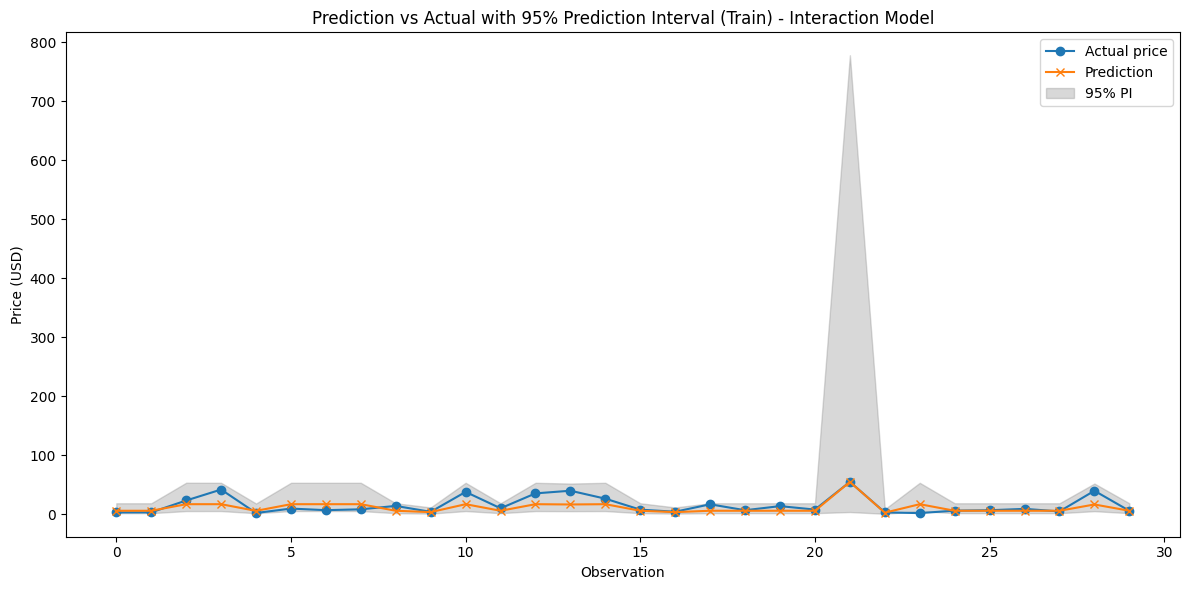

In [48]:
# Original-scale (USD) predictions with interaction model
predicciones_int = modelo_int.get_prediction(exog=X_train_int).summary_frame(alpha=0.05).reset_index()

# Retransform to original scale
predicciones_int['prediccion_usd'] = np.exp(predicciones_int['mean'])
predicciones_int['ic_inf_usd'] = np.exp(predicciones_int['obs_ci_lower'])
predicciones_int['ic_sup_usd'] = np.exp(predicciones_int['obs_ci_upper'])
predicciones_int['precio_real_usd'] = np.exp(y_train.values)

# Plot first 30 observations
n = 30
plt.figure(figsize=(12, 6))
plt.plot(predicciones_int['precio_real_usd'][:n], label='Actual price', marker='o')
plt.plot(predicciones_int['prediccion_usd'][:n], label='Prediction', marker='x')
plt.fill_between(
    predicciones_int.index[:n],
    predicciones_int['ic_inf_usd'][:n],
    predicciones_int['ic_sup_usd'][:n],
    color='gray', alpha=0.3, label='95% PI'
)
plt.xlabel('Observation')
plt.ylabel('Price (USD)')
plt.title('Prediction vs Actual with 95% Prediction Interval (Train) - Interaction Model')
plt.legend()
plt.tight_layout()
plt.show()

## Evaluation Summary and Next Steps

**Key Metrics (test set, lakhs):**
- Robust OLS (log target → price, HC3 errors): RMSE **11.52**, MAE **6.32**, R² **0.284**.
- Interaction-augmented OLS: RMSE **11.52**, MAE **6.32**, R² **0.284** (no measurable lift vs baseline).
- Linear baselines (5-fold CV): RMSE **11.74** on the original target, **11.59** after log-transform plus bias correction (MAE **8.97** vs **8.19**).

**Performance Interpretation:**
- Log-transforming price stabilizes variance and improves residual behavior relative to fitting the original target.
- HC3 robust errors provide reliable inference under heteroscedasticity; additional interaction terms tested here do not yet improve accuracy.
- Retransformation bias correction (`exp(MSE/2)`) keeps log-scale predictions approximately unbiased when mapped back to price.

**Next Steps:**
1. Train regularized regression models (Ridge/Lasso/Elastic Net) to control multicollinearity and prioritize features with true signal.
2. Evaluate non-linear tree-based ensembles (Gradient Boosting, Random Forest, XGBoost) for potential accuracy gains and better interaction handling.
3. Engineer richer interaction or spline terms for age × mileage and power × transmission beyond the manual combinations tested here.
4. Compute SHAP values to communicate feature impact and to verify stability across model classes.
5. Segment models by body type or fuel type to capture heterogeneous pricing dynamics.
